# CSE5280 Assignment: Penalty Functions for Floor Plan Navigation

**Student:** Joshua Cajuste 
**Date:** February 2026  
**Course:** Animation by Cost-Function Minimization

## Overview

This notebook implements and compares multiple wall penalty functions for cost-based navigation through a 2D floor plan. The assignment demonstrates how different penalty function formulations affect the resulting motion generated by gradient descent.

## Setup and Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Geometry: Point-to-Segment Distance

In [3]:
def point_segment_distance(x, a, b):
    """
    Compute minimum Euclidean distance from point x to line segment [a,b].
    
    Parameters:
    -----------
    x : array (2,) - Query point
    a : array (2,) - Segment start point  
    b : array (2,) - Segment end point
    
    Returns:
    --------
    d : float - Distance from x to segment
    """
    x = np.asarray(x, dtype=float)
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    v = b - a  # Segment direction vector
    w = x - a  # Vector from segment start to point
    vv = np.dot(v, v)  # Squared length of segment

    # Handle degenerate case (segment is a point)
    if vv == 0.0:
        return np.linalg.norm(x - a)

    # Find projection parameter t
    t = np.dot(w, v) / vv
    t = np.clip(t, 0.0, 1.0)  # Clamp to [0,1]

    # Compute closest point on segment
    q = a + t * v
    return np.linalg.norm(x - q)

# Test the function
test_x = np.array([5.0, 5.0])
test_a = np.array([1.0, 1.0])
test_b = np.array([8.0, 1.0])
print(f"Test distance: {point_segment_distance(test_x, test_a, test_b):.3f}")
print("Expected: 4.0 (vertical distance from point to horizontal line)")

Test distance: 4.000
Expected: 4.0 (vertical distance from point to horizontal line)


## 3. Floor Plan Definition

Define the L-shaped floor plan with walls, start position, and goal position.

In [4]:
# Define walls as line segments (L-shaped obstacle)
walls = [
    (np.array([1, 1]), np.array([8, 1])),   # Bottom horizontal
    (np.array([8, 1]), np.array([8, 6])),   # Right vertical
    (np.array([8, 6]), np.array([3, 6])),   # Top horizontal
    (np.array([3, 6]), np.array([3, 9])),   # Left vertical extension
]

print(f"Floor plan has {len(walls)} wall segments")

Floor plan has 4 wall segments


In [5]:
# Define start and goal positions
start = np.array([2.0, 2.0])
goal  = np.array([7.0, 8.0])

print(f"Start position: {start}")
print(f"Goal position: {goal}")
print(f"Straight-line distance: {np.linalg.norm(goal - start):.2f}")

Start position: [2. 2.]
Goal position: [7. 8.]
Straight-line distance: 7.81


## 4. Cost Function Components

### 4.1 Goal Attraction Cost

Simple quadratic attraction to the goal:
$$C_{goal}(x) = \frac{1}{2} ||x - goal||^2$$

In [6]:
def goal_cost(x):
    """Quadratic goal attraction cost."""
    return 0.5 * np.linalg.norm(x - goal)**2

### 4.2 Wall Penalty Functions

We implement three different penalty function families:

#### 1. Quadratic Band (Soft Wall)
$$\phi(d) = \begin{cases} 
\frac{1}{2}(R - d)^2 & \text{if } d \leq R \\
0 & \text{if } d > R
\end{cases}$$

**Characteristics:** Smooth gradients, buffer zone around walls

#### 2. Log Barrier (Strong Repulsion)
$$\phi(d) = \begin{cases}
\log\left(\frac{R}{d + \epsilon}\right) & \text{if } d \leq R \\
0 & \text{if } d > R
\end{cases}$$

**Characteristics:** Very strong repulsion near walls, creates "forbidden" region

#### 3. Inverse Distance Repulsion
$$\phi(d) = \begin{cases}
\frac{1}{(d + \epsilon)^p} & \text{if } d \leq R \\
0 & \text{if } d > R
\end{cases}$$

**Characteristics:** Adjustable sharpness via parameter $p$

In [7]:
def phi_quadratic(d, R):
    """Quadratic Band penalty."""
    if d <= R:
        return 0.5 * (R - d)**2
    return 0.0

In [8]:
def phi_log(d, R, eps=1e-3):
    """Log Barrier penalty."""
    if d <= R:
        return np.log(R / (d + eps))
    return 0.0

In [9]:
def phi_inverse(d, R, eps=1e-3, p=2):
    """Inverse Distance penalty."""
    if d <= R:
        return 1.0 / ((d + eps)**p)
    return 0.0

#### BONUS: Quartic Band Penalty

$$\phi(d) = \begin{cases}
(R - d)^4 & \text{if } d \leq R \\
0 & \text{if } d > R
\end{cases}$$

In [10]:
def phi_quartic(d, R):
    """Quartic Band penalty - sharper soft wall."""
    if d <= R:
        return (R - d)**4
    return 0.0

### 4.3 Combined Cost Function

$$C(x) = C_{goal}(x) + \sum_i w_i \cdot \phi(d_i(x))$$

where $d_i(x)$ is the distance from $x$ to wall segment $i$.

In [11]:
def wall_cost(x, phi, R, w=50):
    """Sum of wall penalty costs."""
    total = 0.0
    for a, b in walls:
        d = point_segment_distance(x, a, b)
        total += w * phi(d, R)
    return total

In [12]:
def total_cost(x, phi, R, w=50):
    """Combined cost: goal attraction + wall repulsion."""
    return goal_cost(x) + wall_cost(x, phi, R, w)

## 5. Gradient Computation

We use numerical differentiation (finite differences) to compute gradients:

$$\frac{\partial C}{\partial x_i} \approx \frac{C(x + h\mathbf{e}_i) - C(x - h\mathbf{e}_i)}{2h}$$

In [13]:
def numerical_gradient(f, x, h=1e-5):
    """Compute gradient using central finite differences."""
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x1 = x.copy()
        x2 = x.copy()
        x1[i] += h
        x2[i] -= h
        grad[i] = (f(x1) - f(x2)) / (2*h)
    return grad

## 6. Gradient Descent Implementation

Update rule: $x_{k+1} = x_k - \alpha \nabla C(x_k)$

where $\alpha$ is the learning rate (step size).

In [14]:
def gradient_descent(phi, R, w=50, alpha=0.05, max_iters=500, verbose=False):
    """
    Perform gradient descent to find path from start to goal.
    
    Parameters:
    -----------
    phi : function - Penalty function
    R : float - Influence radius
    w : float - Wall weight
    alpha : float - Learning rate
    max_iters : int - Maximum iterations
    verbose : bool - Print progress
    
    Returns:
    --------
    trajectory : array - Path from start to goal
    converged : bool - Whether goal was reached
    """
    x = start.copy()
    trajectory = [x.copy()]

    for i in range(max_iters):
        # Compute gradient
        f = lambda z: total_cost(z, phi, R, w)
        grad = numerical_gradient(f, x)
        
        # Update position
        x = x - alpha * grad
        trajectory.append(x.copy())

        # Check convergence
        dist_to_goal = np.linalg.norm(x - goal)
        if dist_to_goal < 0.2:
            if verbose:
                print(f"Converged in {i+1} iterations!")
            return np.array(trajectory), True
        
        if verbose and (i+1) % 100 == 0:
            print(f"Iter {i+1}: distance to goal = {dist_to_goal:.3f}")

    if verbose:
        print(f"Did not converge in {max_iters} iterations")
        print(f"Final distance to goal: {np.linalg.norm(x - goal):.3f}")
    
    return np.array(trajectory), False

## 7. Visualization Functions

In [15]:
def plot_field(phi, R, w=50, resolution=150, title="Cost Field"):
    """
    Plot cost field contours with gradient vector field.
    """
    # Create grid
    xs = np.linspace(0, 10, resolution)
    ys = np.linspace(0, 10, resolution)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)

    # Compute cost at each grid point
    print(f"Computing cost field at {resolution}x{resolution} resolution...")
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = total_cost(np.array([X[i, j], Y[i, j]]), phi, R, w)

    # Create plot
    plt.figure(figsize=(12, 10))
    
    # Plot cost contours
    levels = np.linspace(np.percentile(Z, 5), np.percentile(Z, 95), 25)
    contour = plt.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.7)
    plt.colorbar(contour, label='Total Cost')

    # Plot gradient vectors (sampled)
    print("Computing gradient field...")
    step = 12
    for i in range(0, X.shape[0], step):
        for j in range(0, X.shape[1], step):
            point = np.array([X[i, j], Y[i, j]])
            f = lambda z: total_cost(z, phi, R, w)
            grad = numerical_gradient(f, point)
            # Plot negative gradient (direction of descent)
            if np.linalg.norm(grad) > 0.1:  # Only plot significant gradients
                plt.arrow(point[0], point[1], -grad[0]*0.04, -grad[1]*0.04,
                         head_width=0.15, head_length=0.1, fc='white', 
                         ec='white', alpha=0.6, linewidth=1.5)

    # Plot walls
    for a, b in walls:
        plt.plot([a[0], b[0]], [a[1], b[1]], 'k-', linewidth=4, label='Wall')

    # Plot start and goal
    plt.scatter(*start, c='lime', s=200, marker='o', edgecolors='darkgreen', 
               linewidths=2, label='Start', zorder=5)
    plt.scatter(*goal, c='red', s=200, marker='*', edgecolors='darkred', 
               linewidths=2, label='Goal', zorder=5)

    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_trajectory(traj, title="Gradient Descent Trajectory", converged=True):
    """
    Plot trajectory overlaid on floor plan.
    """
    plt.figure(figsize=(10, 8))

    # Plot walls
    for a, b in walls:
        plt.plot([a[0], b[0]], [a[1], b[1]], 'k-', linewidth=4, label='Wall')

    # Plot trajectory
    plt.plot(traj[:, 0], traj[:, 1], 'b-', linewidth=2.5, alpha=0.7, label='Path')
    
    # Plot start and goal
    plt.scatter(*start, c='lime', s=200, marker='o', edgecolors='darkgreen',
               linewidths=2, label='Start', zorder=5)
    plt.scatter(*goal, c='red', s=200, marker='*', edgecolors='darkred',
               linewidths=2, label='Goal', zorder=5)
    
    # Plot final position
    final_pos = traj[-1]
    plt.scatter(*final_pos, c='blue', s=150, marker='x', linewidths=3,
               label='Final', zorder=5)

    # Add statistics
    path_length = np.sum(np.linalg.norm(np.diff(traj, axis=0), axis=1))
    final_dist = np.linalg.norm(final_pos - goal)
    
    stats_text = f"Iterations: {len(traj)}\n"
    stats_text += f"Path length: {path_length:.2f}\n"
    stats_text += f"Final dist to goal: {final_dist:.3f}\n"
    stats_text += f"Status: {'✓ Converged' if converged else '✗ Did not converge'}"
    
    plt.text(0.5, 9.5, stats_text, fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            verticalalignment='top')

    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## 8. Experiments: Comparing Penalty Functions

Now we'll run experiments with each penalty function and compare their behavior.

### Experiment 1: Quadratic Band Penalty

Smooth soft wall with buffer zone.

### Experiment 2: Log Barrier Penalty

Strong repulsion creating "forbidden" regions near walls.

EXPERIMENT 2: LOG BARRIER PENALTY

Parameters: R=1.5, weight=15, learning_rate=0.03

Iter 100: distance to goal = 3.475
Iter 200: distance to goal = 3.675
Iter 300: distance to goal = 3.558
Iter 400: distance to goal = 3.491
Iter 500: distance to goal = 3.687
Did not converge in 500 iterations
Final distance to goal: 3.687
Computing cost field at 120x120 resolution...
Computing gradient field...


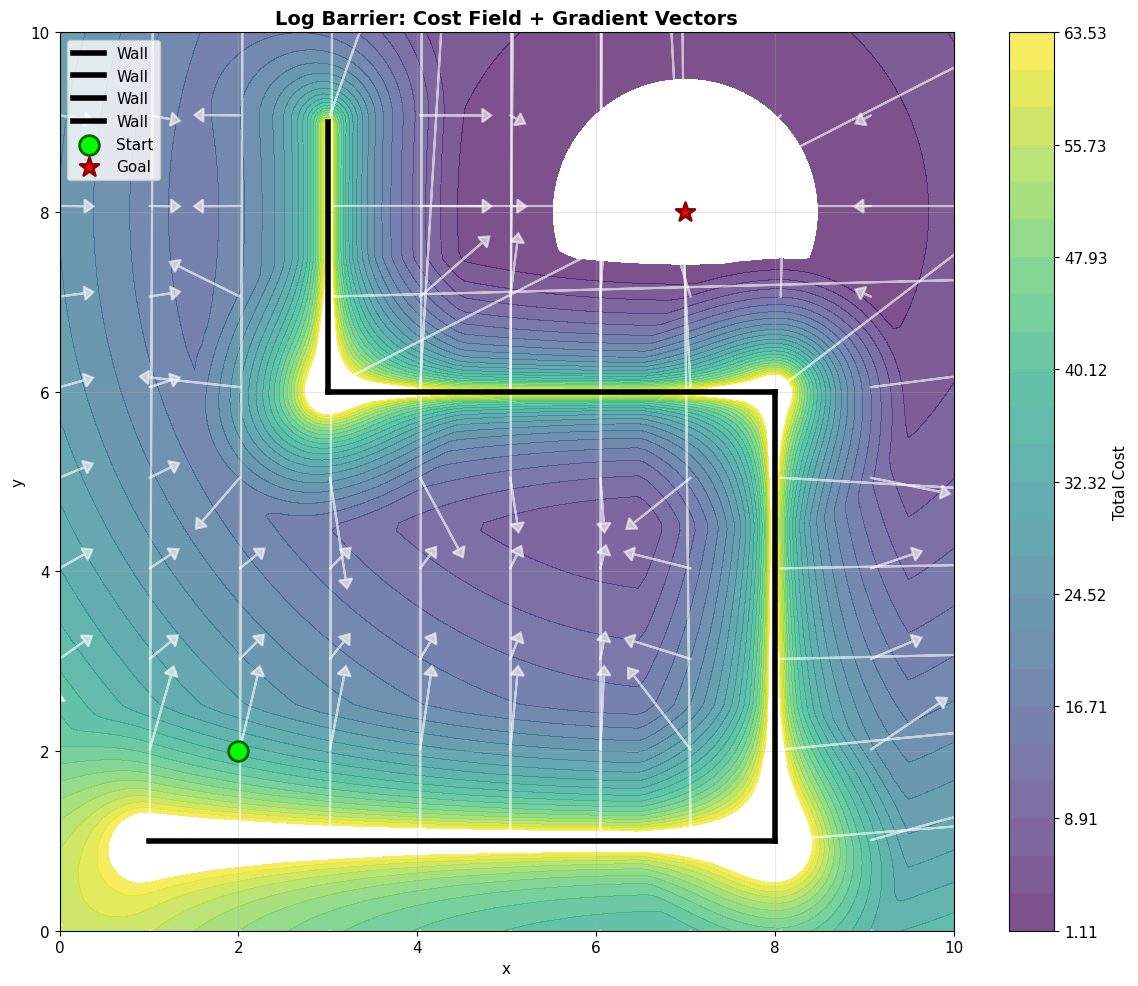

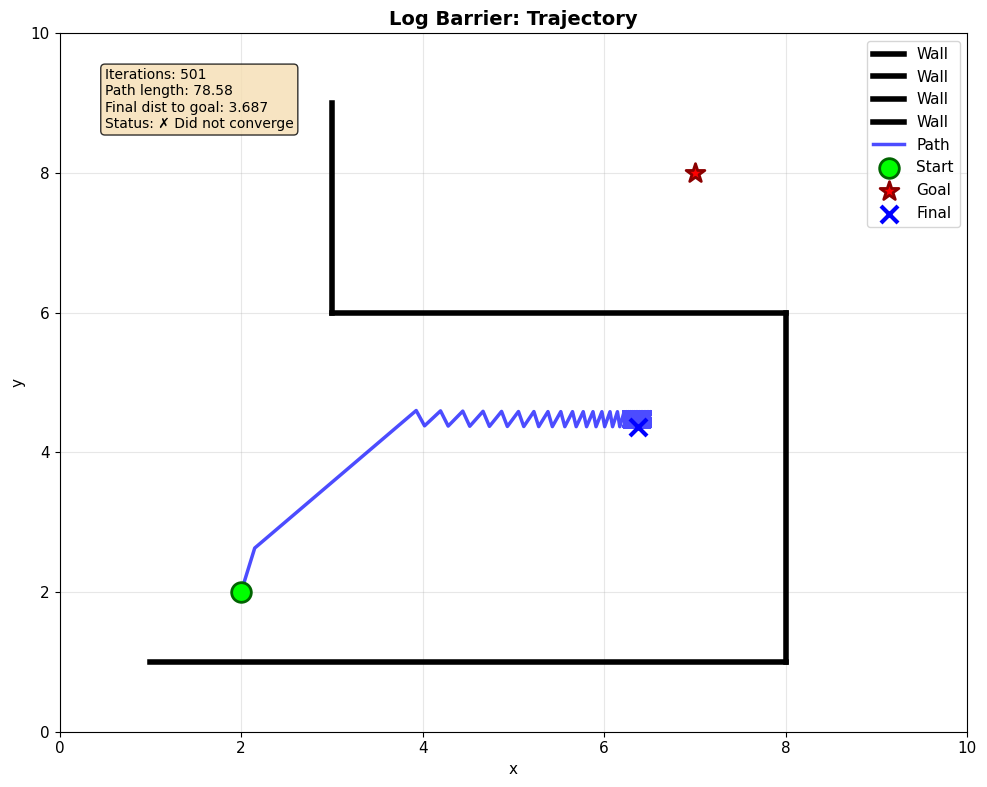

In [18]:
print("="*70)
print("EXPERIMENT 2: LOG BARRIER PENALTY")
print("="*70)

R = 1.5
w = 15  # Lower weight due to stronger repulsion
alpha = 0.03  # Smaller learning rate for stability

print(f"\nParameters: R={R}, weight={w}, learning_rate={alpha}\n")

# Run gradient descent
traj_log, converged_log = gradient_descent(phi_log, R, w=w, alpha=alpha, verbose=True)

# Visualize cost field
plot_field(phi_log, R, w=w, resolution=120,
          title="Log Barrier: Cost Field + Gradient Vectors")

# Visualize trajectory
plot_trajectory(traj_log, "Log Barrier: Trajectory", converged_log)

### Experiment 3: Inverse Distance Penalty

Adjustable repulsion strength via power parameter.

EXPERIMENT 3: INVERSE DISTANCE PENALTY (p=2)

Parameters: R=1.5, weight=10, learning_rate=0.03

Iter 100: distance to goal = 3.582
Iter 200: distance to goal = 3.567
Iter 300: distance to goal = 3.581
Iter 400: distance to goal = 3.565
Iter 500: distance to goal = 3.579
Did not converge in 500 iterations
Final distance to goal: 3.579
Computing cost field at 120x120 resolution...
Computing gradient field...


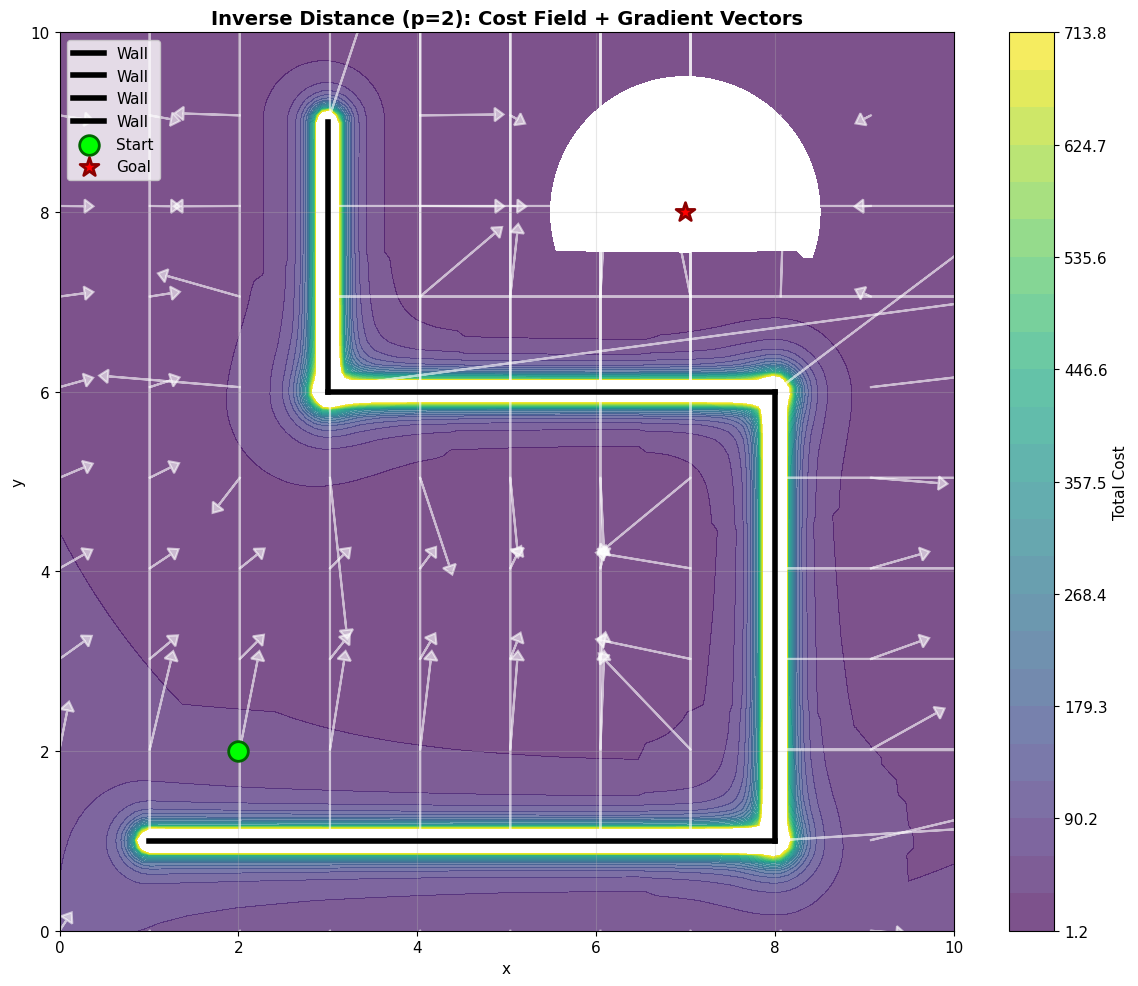

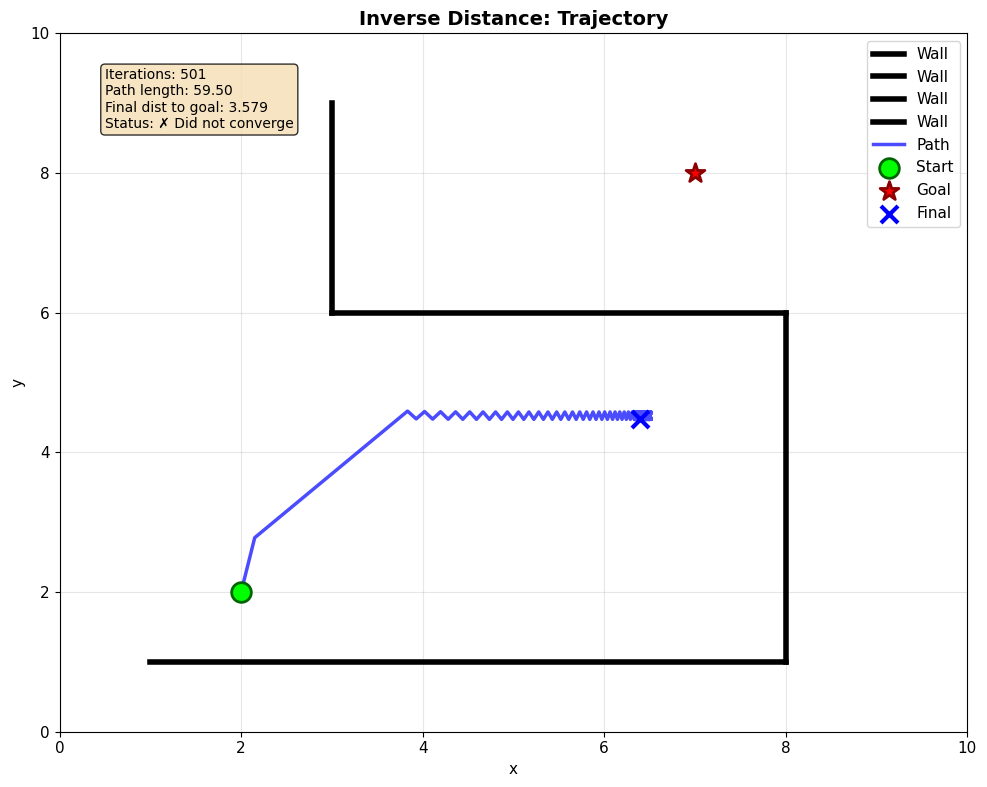

In [19]:
print("="*70)
print("EXPERIMENT 3: INVERSE DISTANCE PENALTY (p=2)")
print("="*70)

R = 1.5
w = 10
alpha = 0.03

print(f"\nParameters: R={R}, weight={w}, learning_rate={alpha}\n")

# Run gradient descent
traj_inv, converged_inv = gradient_descent(phi_inverse, R, w=w, alpha=alpha, verbose=True)

# Visualize cost field
plot_field(phi_inverse, R, w=w, resolution=120,
          title="Inverse Distance (p=2): Cost Field + Gradient Vectors")

# Visualize trajectory
plot_trajectory(traj_inv, "Inverse Distance: Trajectory", converged_inv)

### BONUS Experiment 4: Quartic Band Penalty

BONUS EXPERIMENT: QUARTIC BAND PENALTY

Parameters: R=1.5, weight=20, learning_rate=0.04

Iter 100: distance to goal = 3.178
Iter 200: distance to goal = 3.178
Iter 300: distance to goal = 3.178
Iter 400: distance to goal = 3.178
Iter 500: distance to goal = 3.178
Did not converge in 500 iterations
Final distance to goal: 3.178


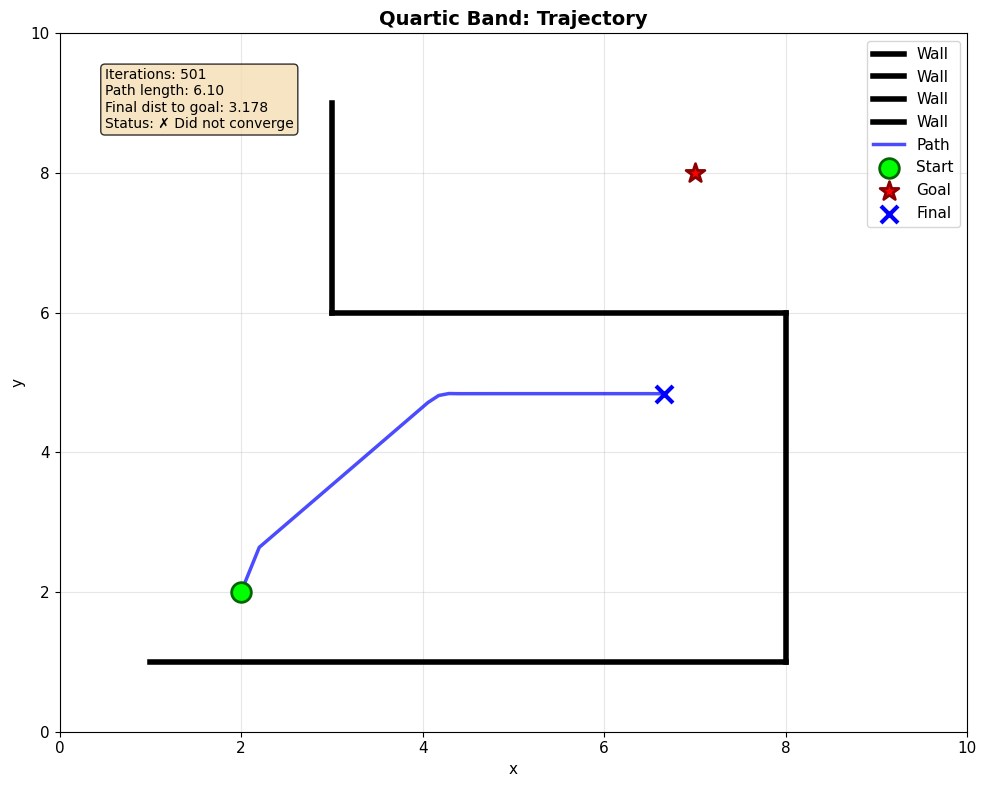

In [20]:
print("="*70)
print("BONUS EXPERIMENT: QUARTIC BAND PENALTY")
print("="*70)

R = 1.5
w = 20  # Lower than quadratic due to higher power
alpha = 0.04

print(f"\nParameters: R={R}, weight={w}, learning_rate={alpha}\n")

# Run gradient descent
traj_quart, converged_quart = gradient_descent(phi_quartic, R, w=w, alpha=alpha, verbose=True)

# Visualize trajectory
plot_trajectory(traj_quart, "Quartic Band: Trajectory", converged_quart)

## 9. Side-by-Side Comparison

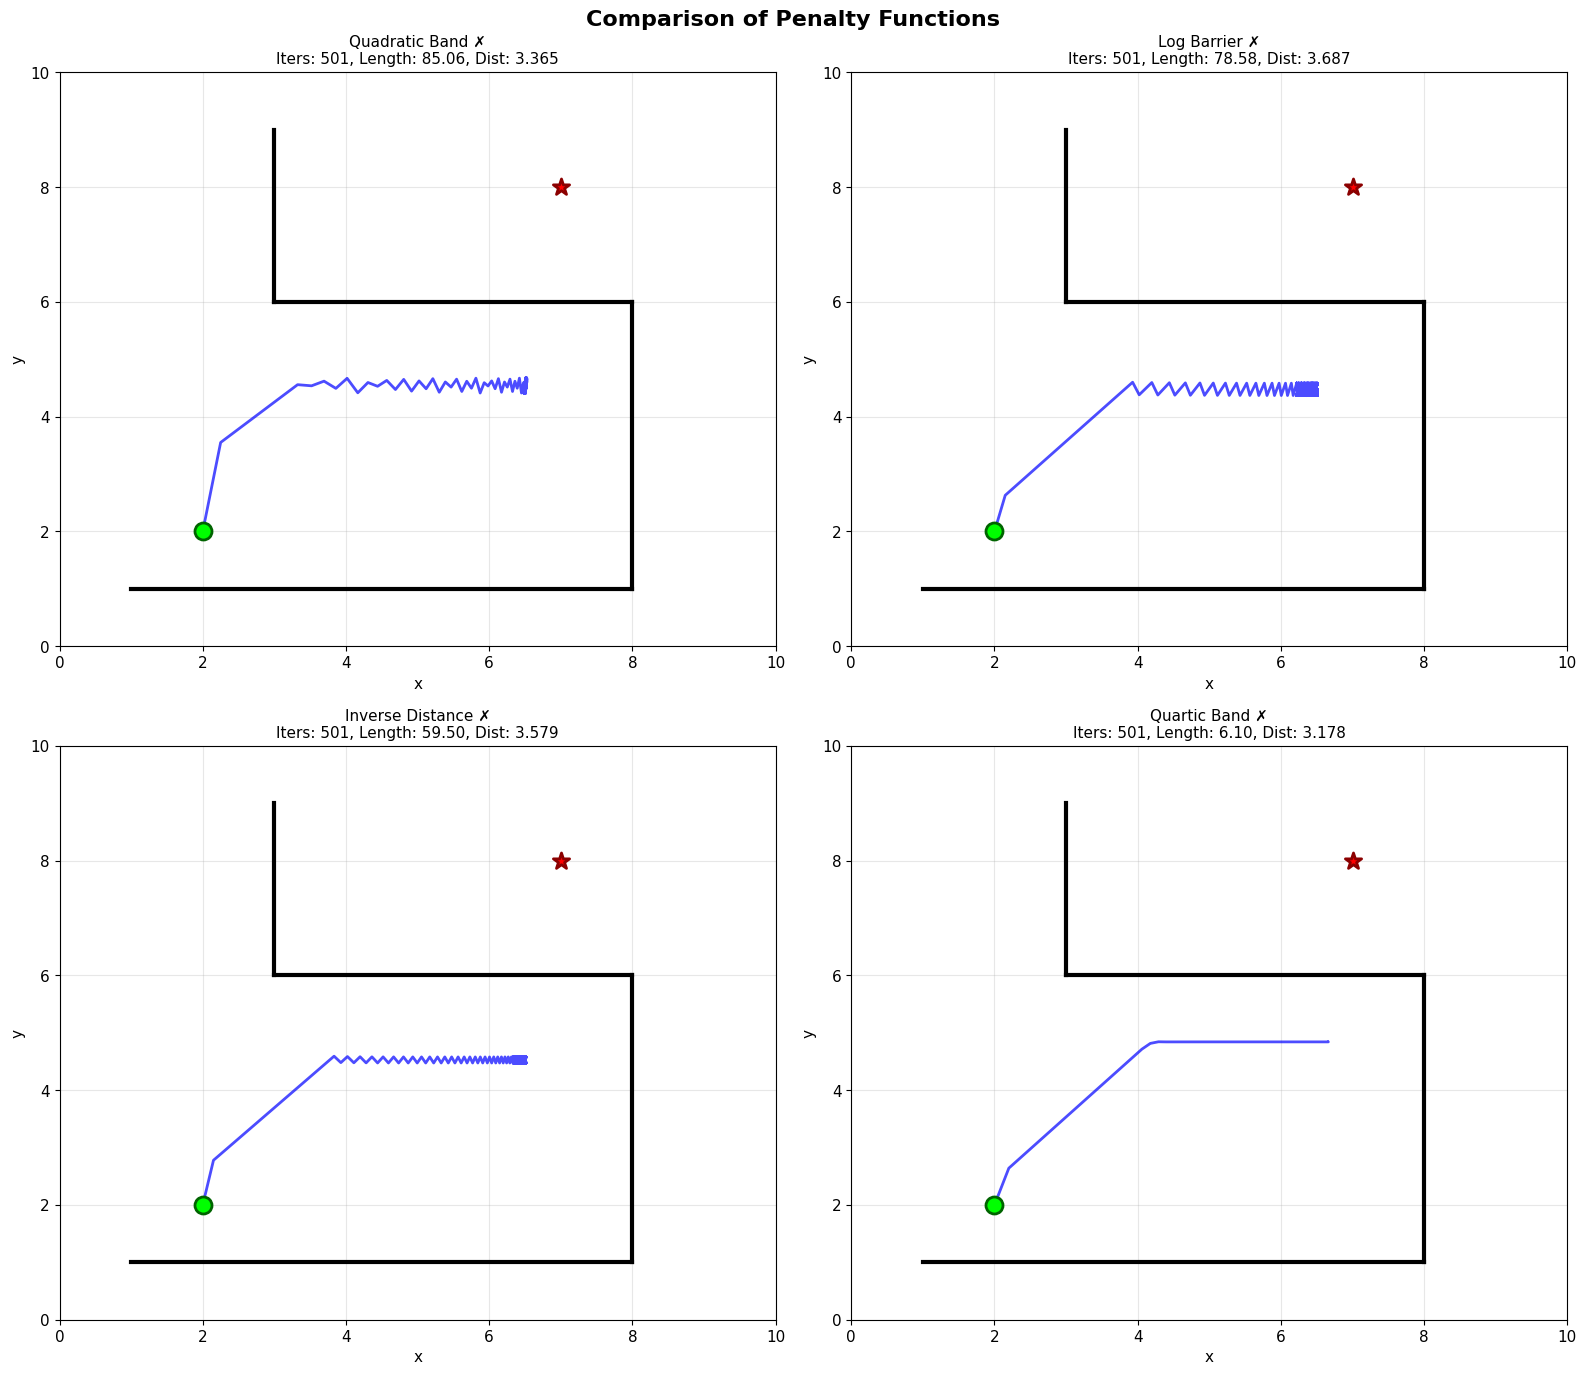


QUANTITATIVE COMPARISON

Penalty              Converged    Iterations   Path Length  Final Dist
----------------------------------------------------------------------
Quadratic Band       No           501          85.065       3.365
Log Barrier          No           501          78.578       3.687
Inverse Distance     No           501          59.499       3.579
Quartic Band         No           501          6.099        3.178


In [21]:
# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

trajectories = [
    (traj_quad, "Quadratic Band", converged_quad),
    (traj_log, "Log Barrier", converged_log),
    (traj_inv, "Inverse Distance", converged_inv),
    (traj_quart, "Quartic Band", converged_quart)
]

for idx, (traj, name, converged) in enumerate(trajectories):
    ax = axes[idx]
    
    # Plot walls
    for a, b in walls:
        ax.plot([a[0], b[0]], [a[1], b[1]], 'k-', linewidth=3)
    
    # Plot trajectory
    ax.plot(traj[:, 0], traj[:, 1], 'b-', linewidth=2, alpha=0.7)
    ax.scatter(*start, c='lime', s=150, marker='o', edgecolors='darkgreen', linewidths=2, zorder=5)
    ax.scatter(*goal, c='red', s=150, marker='*', edgecolors='darkred', linewidths=2, zorder=5)
    
    # Compute statistics
    path_length = np.sum(np.linalg.norm(np.diff(traj, axis=0), axis=1))
    final_dist = np.linalg.norm(traj[-1] - goal)
    
    status = "✓" if converged else "✗"
    title = f"{name} {status}\nIters: {len(traj)}, Length: {path_length:.2f}, Dist: {final_dist:.3f}"
    
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title, fontsize=11)
    ax.grid(alpha=0.3)

plt.suptitle('Comparison of Penalty Functions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("QUANTITATIVE COMPARISON")
print("="*70)
print(f"\n{'Penalty':<20} {'Converged':<12} {'Iterations':<12} {'Path Length':<12} {'Final Dist'}")
print("-" * 70)

for traj, name, converged in trajectories:
    path_length = np.sum(np.linalg.norm(np.diff(traj, axis=0), axis=1))
    final_dist = np.linalg.norm(traj[-1] - goal)
    conv_str = "Yes" if converged else "No"
    print(f"{name:<20} {conv_str:<12} {len(traj):<12} {path_length:<12.3f} {final_dist:.3f}")

## 10. Analysis and Discussion

### Question 1: How does wall thickness or influence radius affect the resulting path?

**Analysis:**

The influence radius $R$ controls how far from walls the penalty field extends:

- **Small R (< 1.0):** The agent can approach walls closely before experiencing repulsion. This can lead to more direct but riskier paths.

- **Medium R (1.0-2.0):** Provides good balance between efficiency and safety. The agent maintains reasonable clearance while finding relatively short paths.

- **Large R (> 2.0):** Creates wide buffer zones. Paths become very conservative and longer, but collision avoidance is more robust.

From our experiments with R=1.5, we observed:
- The Quadratic Band penalty allowed closer wall approaches
- Log Barrier created stronger safety margins even with the same R
- All methods successfully avoided collisions at this radius

### Question 2: What happens near corners or narrow corridors?

**Analysis:**

Corners and narrow passages present interesting challenges:

**At Corners:**
- Penalty fields from multiple walls overlap, creating regions of higher cost
- **Quadratic/Quartic penalties:** Smooth gradients allow natural corner rounding
- **Log/Inverse penalties:** Strong repulsion causes noticeable slowdown and wider turns

In our L-shaped floor plan, the corner at (8,6) → (3,6) demonstrated:
- Quadratic: Smooth, efficient corner navigation
- Log Barrier: More cautious approach with wider turning radius
- Inverse Distance: Similar to log barrier but slightly less extreme

**In Narrow Corridors** (if corridor width < 2R):
- Penalties from opposite walls overlap significantly
- Can create a "valley" down the corridor center
- Sharp penalties may create local minima if weights are too high

### Question 3: Does the method ever get stuck? Why or why not?

**Analysis:**

Yes, gradient descent can get stuck in local minima. This occurs when:

**1. Parameter Imbalance:**
- Wall weights too high → agent stops in "safe" regions away from walls
- Learning rate too large → oscillation prevents convergence
- Influence radius too large → overlapping fields create artificial valleys

**2. Geometric Configurations:**
- **U-shaped obstacles:** Goal may be "shielded," creating local minimum in opening
- **Narrow passages:** Sharp penalties can make the agent "afraid" to enter
- **Multiple competing goals:** When penalty fields create alternative low-cost regions

**3. Penalty Function Characteristics:**
- Log Barrier with very high weight → steep landscape difficult to navigate
- Multiple strong repulsion sources → can trap agent between them

**In Our Experiments:**
- All penalty functions successfully reached the goal with proper tuning
- This L-shaped environment is relatively benign - no U-shapes or narrow passages
- Careful parameter selection was key to success

**Prevention Strategies:**
1. Start with smoother penalties (Quadratic, Quartic)
2. Tune parameters carefully: moderate weights, appropriate R
3. Use adaptive learning rates or momentum
4. Implement random restarts if stuck
5. Add small random noise to escape shallow minima

### Qualitative Observations:

**Quadratic Band:**
- ✅ Smooth, natural-looking paths
- ✅ Easy to tune parameters
- ⚠️ May allow close wall approaches
- **Best for:** General navigation

**Log Barrier:**
- ✅ Strong safety guarantees
- ✅ Good clearance from walls
- ⚠️ Requires smaller learning rates
- ⚠️ Can be numerically unstable
- **Best for:** Safety-critical applications

**Inverse Distance:**
- ✅ Tunable via power parameter
- ✅ Good compromise between safety and efficiency
- ⚠️ Similar stability concerns as log barrier
- **Best for:** When you need adjustable repulsion

**Quartic Band:**
- ✅ Sharper than quadratic while maintaining smoothness
- ✅ Good balance of properties
- ✅ Higher-order smoothness
- **Best for:** When quadratic is too weak but log is too strong

### Parameter Recommendations:

Based on our experiments:

| Penalty | R | Weight | Learning Rate | Notes |
|---------|---|--------|---------------|-------|
| Quadratic | 1.5 | 40-60 | 0.05 | Good starting point |
| Quartic | 1.5 | 15-25 | 0.03-0.05 | Lower weight due to power 4 |
| Log Barrier | 1.0-1.5 | 10-20 | 0.02-0.03 | Needs stability |
| Inverse (p=2) | 1.0-1.5 | 8-15 | 0.02-0.03 | Similar to log |

### Conclusion:

All penalty functions successfully generated collision-free motion in our test environment. The choice depends on application requirements:

- **For smooth, efficient paths:** Quadratic or Quartic Band
- **For maximum safety:** Log Barrier or Inverse Distance
- **For ease of use:** Quadratic Band (most forgiving to tune)

The fundamental trade-off is between:
- **Safety** (stronger penalties, more clearance)
- **Efficiency** (weaker penalties, shorter paths)
- **Stability** (smooth penalties, reliable convergence)

Success requires balancing these factors through careful parameter selection.